In [1]:
import numpy as np
from scipy.optimize import minimize
from scipy.spatial import Delaunay, delaunay_plot_2d

from matplotlib import pyplot as plt


import cvxpy as cp


In [2]:
def target(points, edges):
    # 
    return np.var(np.linalg.norm(points[edges[:, 0]] - points[edges[:, 1]], axis=1))

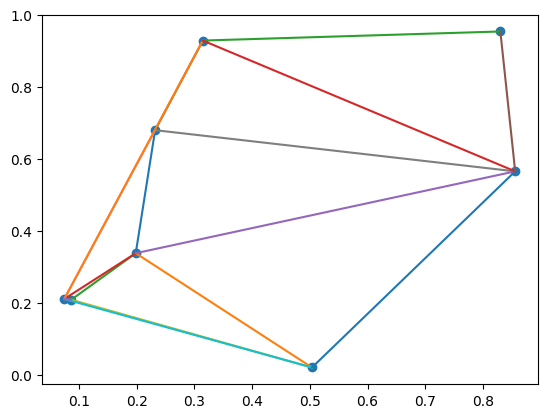

In [3]:
n = 8

points = np.random.random([n, 2])
tri = Delaunay(points)

edges = np.unique(np.sort(np.concatenate([tri.simplices[:, [0, 1]], 
                                          tri.simplices[:, [0, 2]], 
                                          tri.simplices[:, [1, 2]], ]), axis=1), axis=0)


plt.scatter(points[:, 0], points[:, 1], )
for edge in edges:
    plt.plot(points[edge, 0], points[edge, 1], )

In [5]:
# Define optimization variables
opt_points = cp.Variable([n, 2])
opt_points.value = points

# Define the target function in cvxpy
edge_lengths = cp.norm(opt_points[edges[:, 0]] - opt_points[edges[:, 1]], axis=1, p=2)
mean_length = cp.sum(edge_lengths) / len(edges)
squared_deviation = cp.sum_squares(edge_lengths - mean_length)


# Objective to minimize the sum of squared deviations
objective = cp.Minimize(squared_deviation)


# Define constraints to ensure all points are on the same side of each edge
constraints = []
for edge in edges:
    p1, p2 = points[edge]
    a, b = p2[1] - p1[1], p1[0] - p2[0]
    c = -a * p1[0] - b * p1[1]
    # Compute linear equation for all points
    signs = a * opt_points[:, 0] + b * opt_points[:, 1] + c
    # Ensure all signs are either non-negative or non-positive
    constraints.append(signs >= 0)
    constraints.append(signs <= 0)
    
for i in range(n):
    constraints.append(opt_points[i, 0] >= 0)
    constraints.append(opt_points[i, 0] <= 1)
    constraints.append(opt_points[i, 1] >= 0)
    constraints.append(opt_points[i, 1] <= 1)

# Solve the optimization problem
problem = cp.Problem(objective, constraints)
problem.solve()

# Extract optimized points
optimized_points = opt_points.value



print(f'f_old = {target(points, edges):.4f}')
print(f'f_new = {target(optimized_points, edges):.4f}')

fig, axs = plt.subplots(1, 2, figsize=(11, 5))
axs[0].scatter(points[:, 0], points[:, 1], )
for edge in edges:
    axs[0].plot(points[edge, 0], points[edge, 1], )

axs[1].scatter(optimized_points[:, 0], optimized_points[:, 1], )
for edge in edges:
    axs[1].plot(optimized_points[edge, 0], optimized_points[edge, 1], )

plt.show()

DCPError: Problem does not follow DCP rules. Specifically:
The objective is not DCP. Its following subexpressions are not:
Pnorm(var477[0, 0, 0, 0, 0, 1, 1, 1, 2, 2, 2, 3, 3, 3, 4, 6] + -var477[1, 2, 4, 5, 7, 3, 5, 7, 4, 5, 7, 5, 6, 7, 5, 7], 2) + Promote(-Sum(Pnorm(var477[0, 0, 0, 0, 0, 1, 1, 1, 2, 2, 2, 3, 3, 3, 4, 6] + -var477[1, 2, 4, 5, 7, 3, 5, 7, 4, 5, 7, 5, 6, 7, 5, 7], 2), None, False) / 16.0, (16,))